# Import relevant libraries

In [1]:
import numpy as np

# A bunch of stuff from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit import transpile
from qiskit_aer import Aer
from qiskit import QuantumCircuit
from qiskit.circuit import Instruction
from qiskit.transpiler.passes import Optimize1qGatesDecomposition
from qiskit.transpiler import PassManager

# Get the QFT8 circuit

Create and draw standard QFT circuit (comprising H and CPHASE gates)

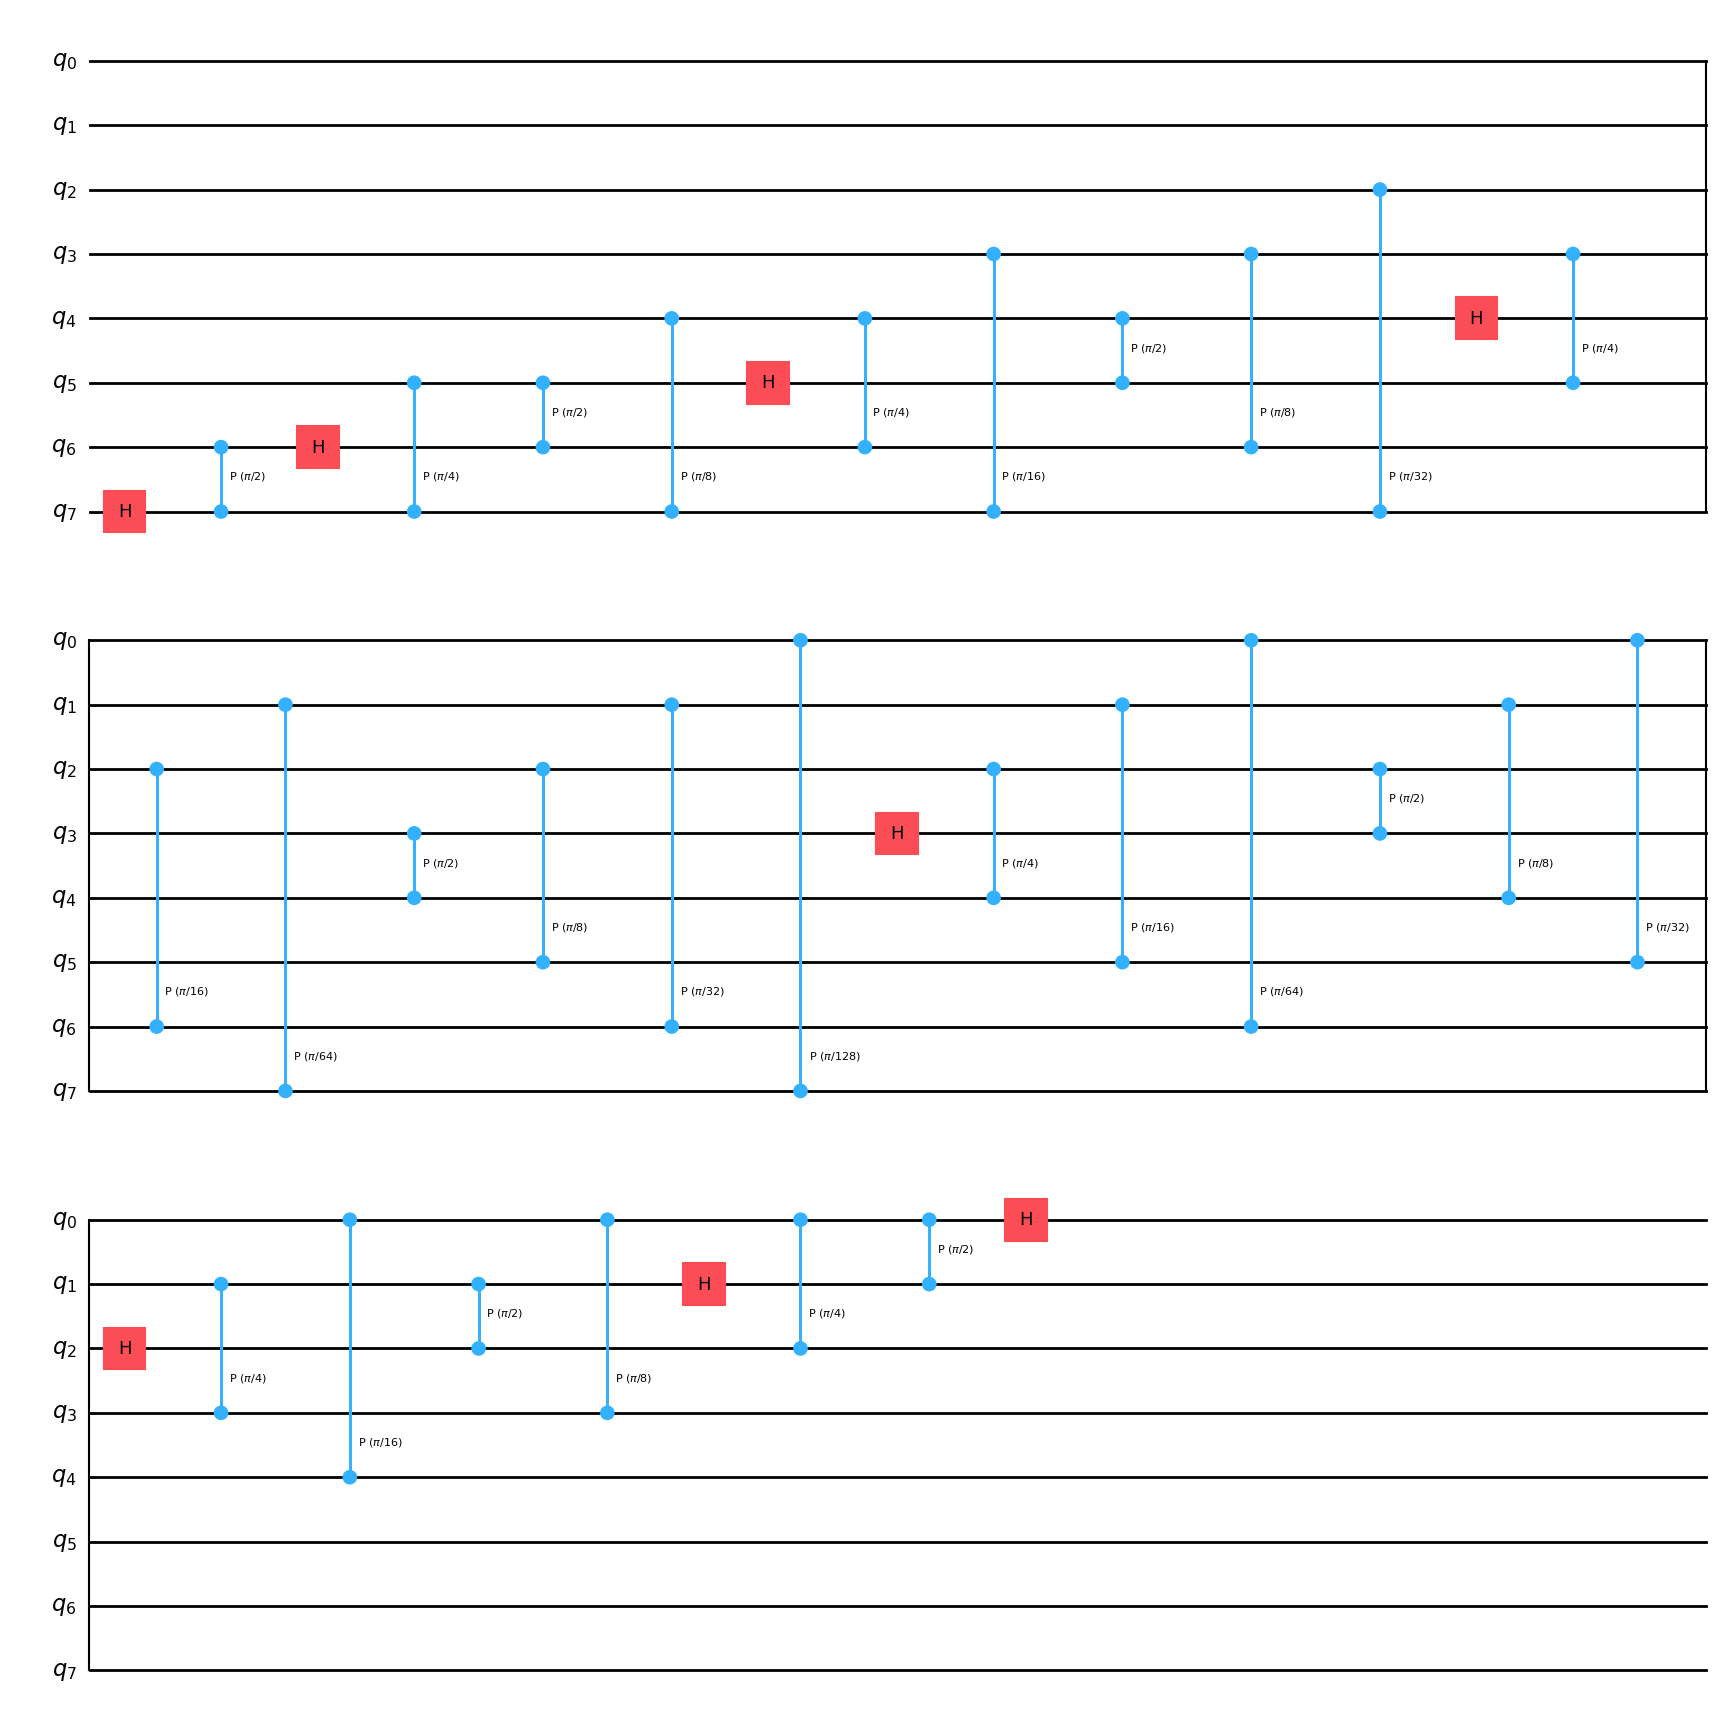

In [2]:
# Create a 8-qubit QFT circuit
qft = QFT(8, do_swaps=False).decompose()

# To draw it
qft.draw("mpl")

First recompile circuit to use CNOTs as the only two qubit gate (and then arbitrary single qubit rotations)

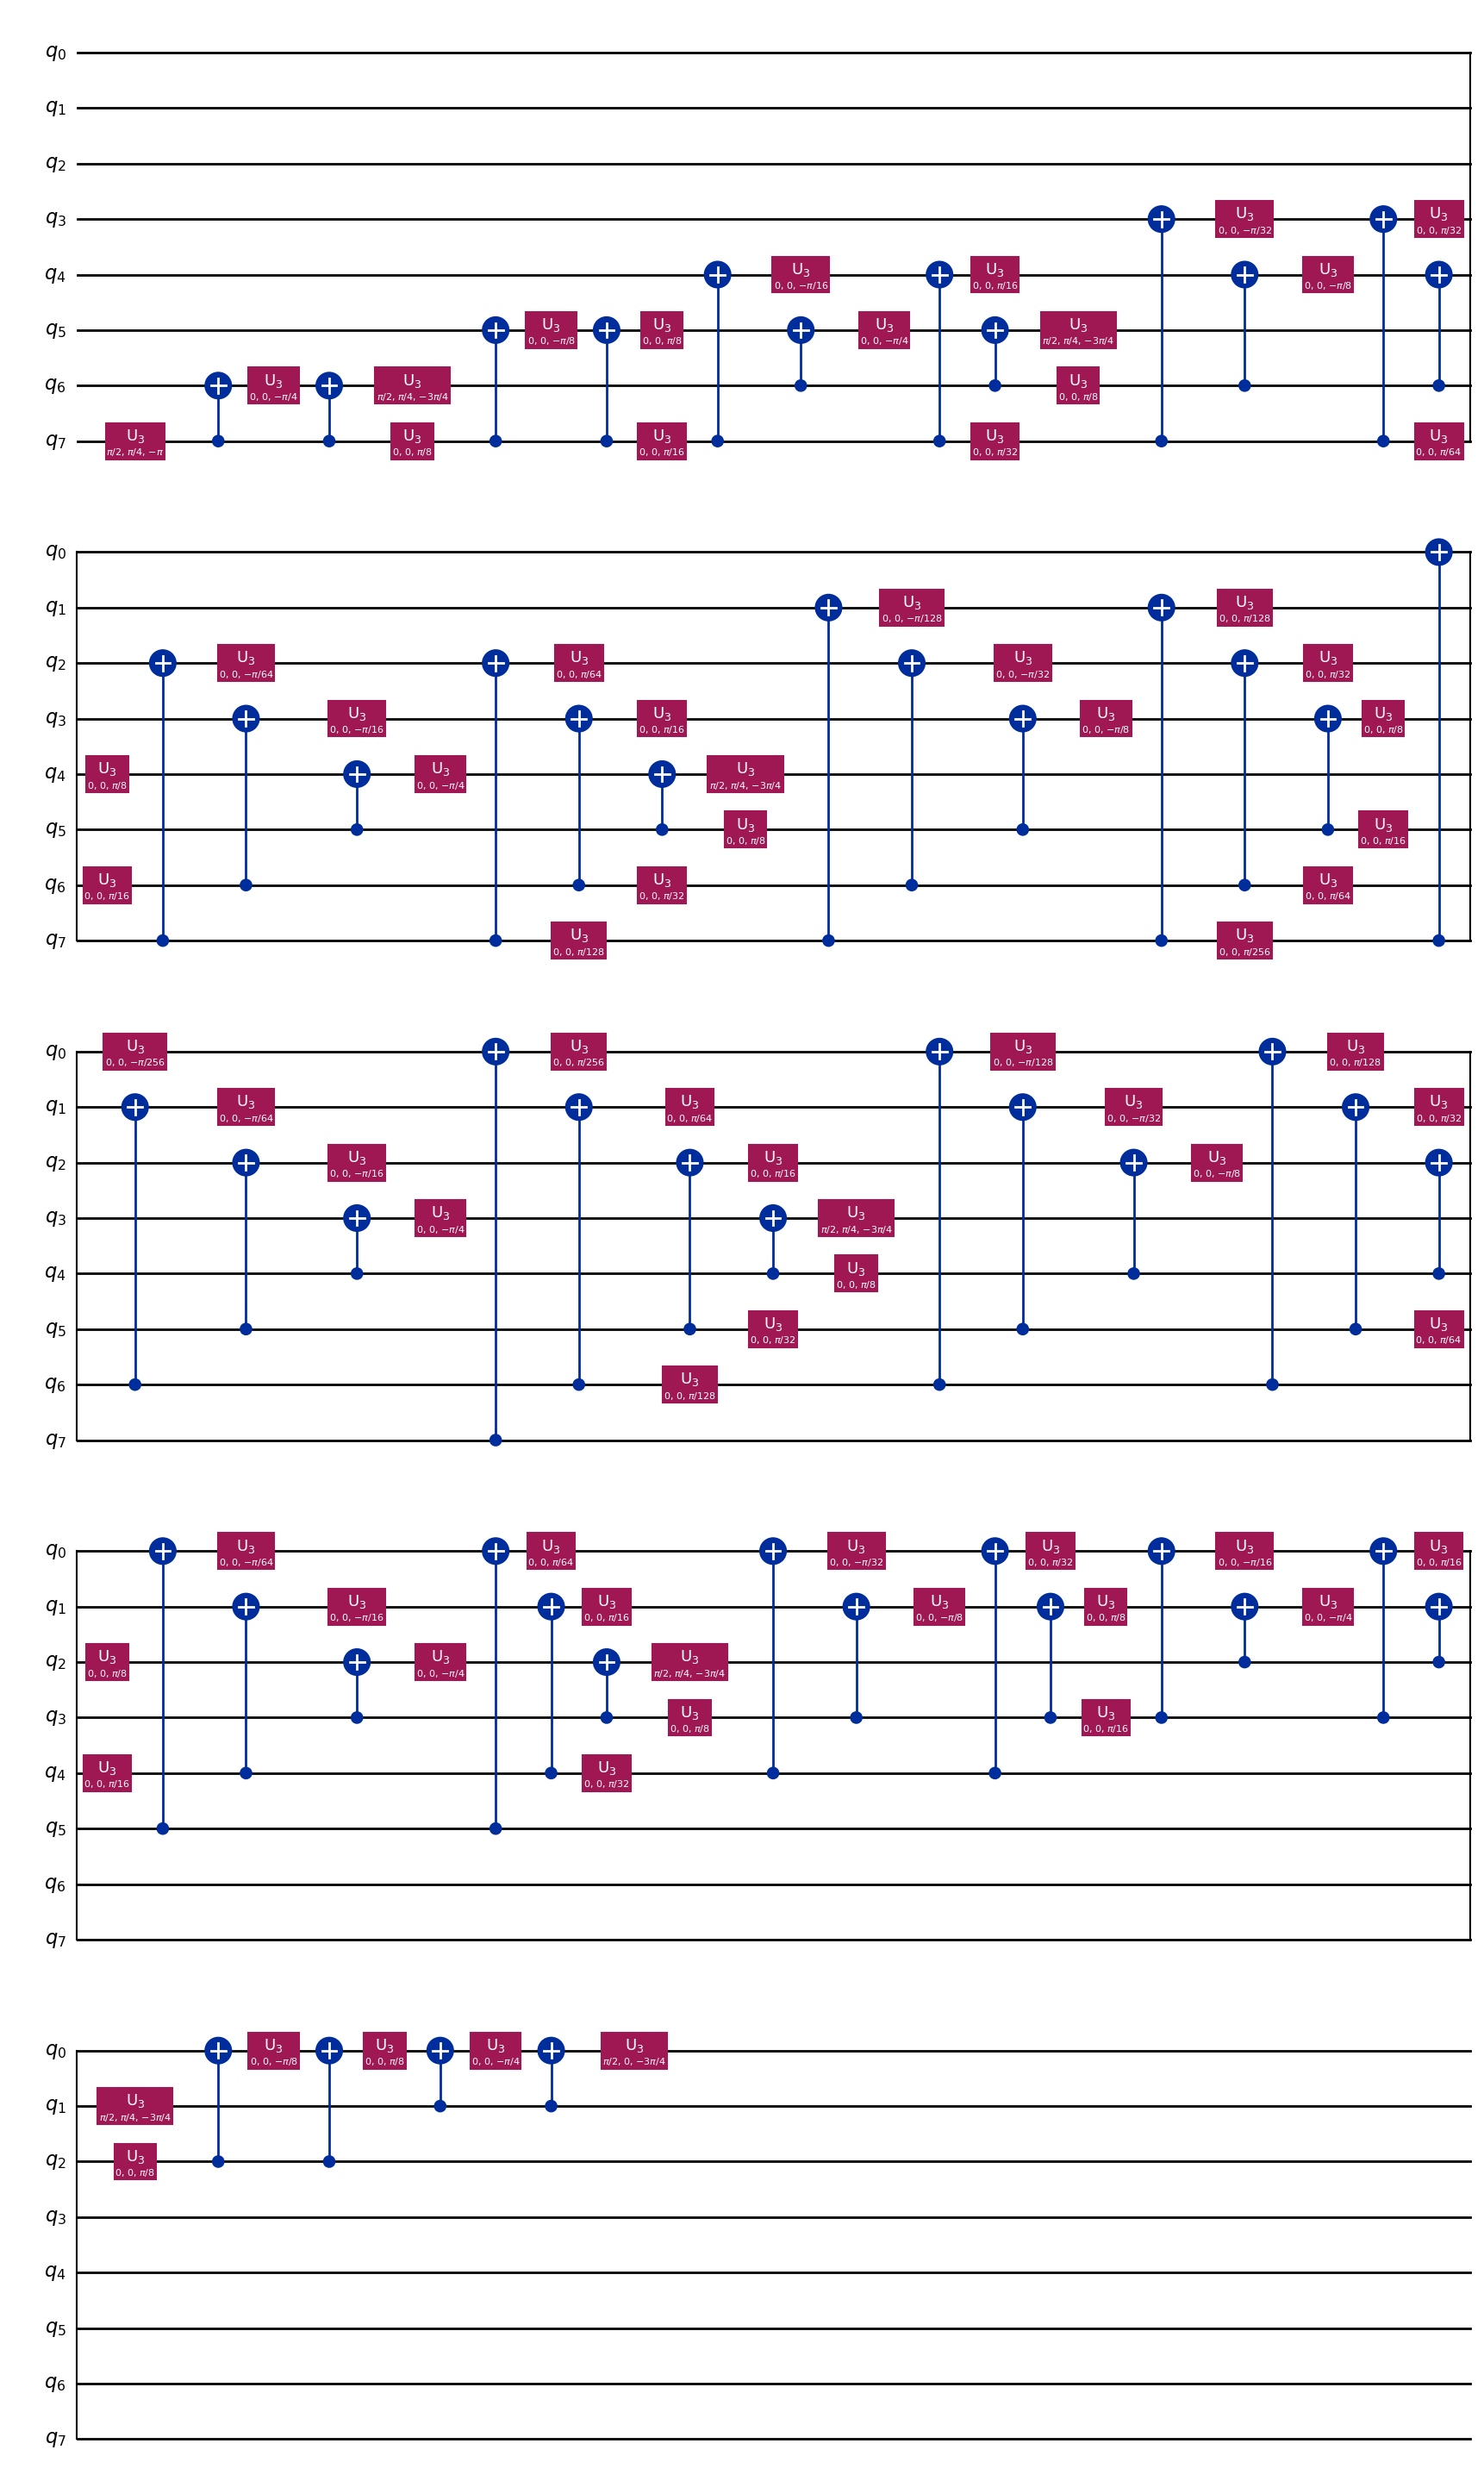

In [3]:
# Use Aer's UnitarySimulator or similar for testing
backend = Aer.get_backend("unitary_simulator")

# Transpile QFT circuit to only use arbitrary 2 qubit rotations and CNOT
compiled_qft = transpile(qft, basis_gates=["u3", "cx"], backend=backend)

compiled_qft.draw("mpl")

Replace CNOTs with the MS gate

In [4]:
# define function to replace CNOT with MS gate

def replace_cnot_with_MSgate(circuit):

    new_circuit = QuantumCircuit(circuit.num_qubits)

    for instr, qargs, cargs in circuit.data:
        qubit_indices = [circuit.qubits.index(q) for q in qargs]
        if instr.name == 'cx':
            ctrl, tgt = qubit_indices
            # Custom replacement for CNOT
            new_circuit.ry(-np.pi/2, ctrl)
            new_circuit.rxx(np.pi/2, ctrl, tgt)
            new_circuit.rx(-np.pi/2, tgt)
            new_circuit.rx(np.pi/2, ctrl)
            new_circuit.ry(-np.pi/2, ctrl)
        
        else:
            new_circuit.append(instr, qubit_indices, cargs)

    return new_circuit

/var/folders/k3/sslkvfs91_53v_sx11v7hzbw0000gn/T/ipykernel_24628/2808873794.py:7: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


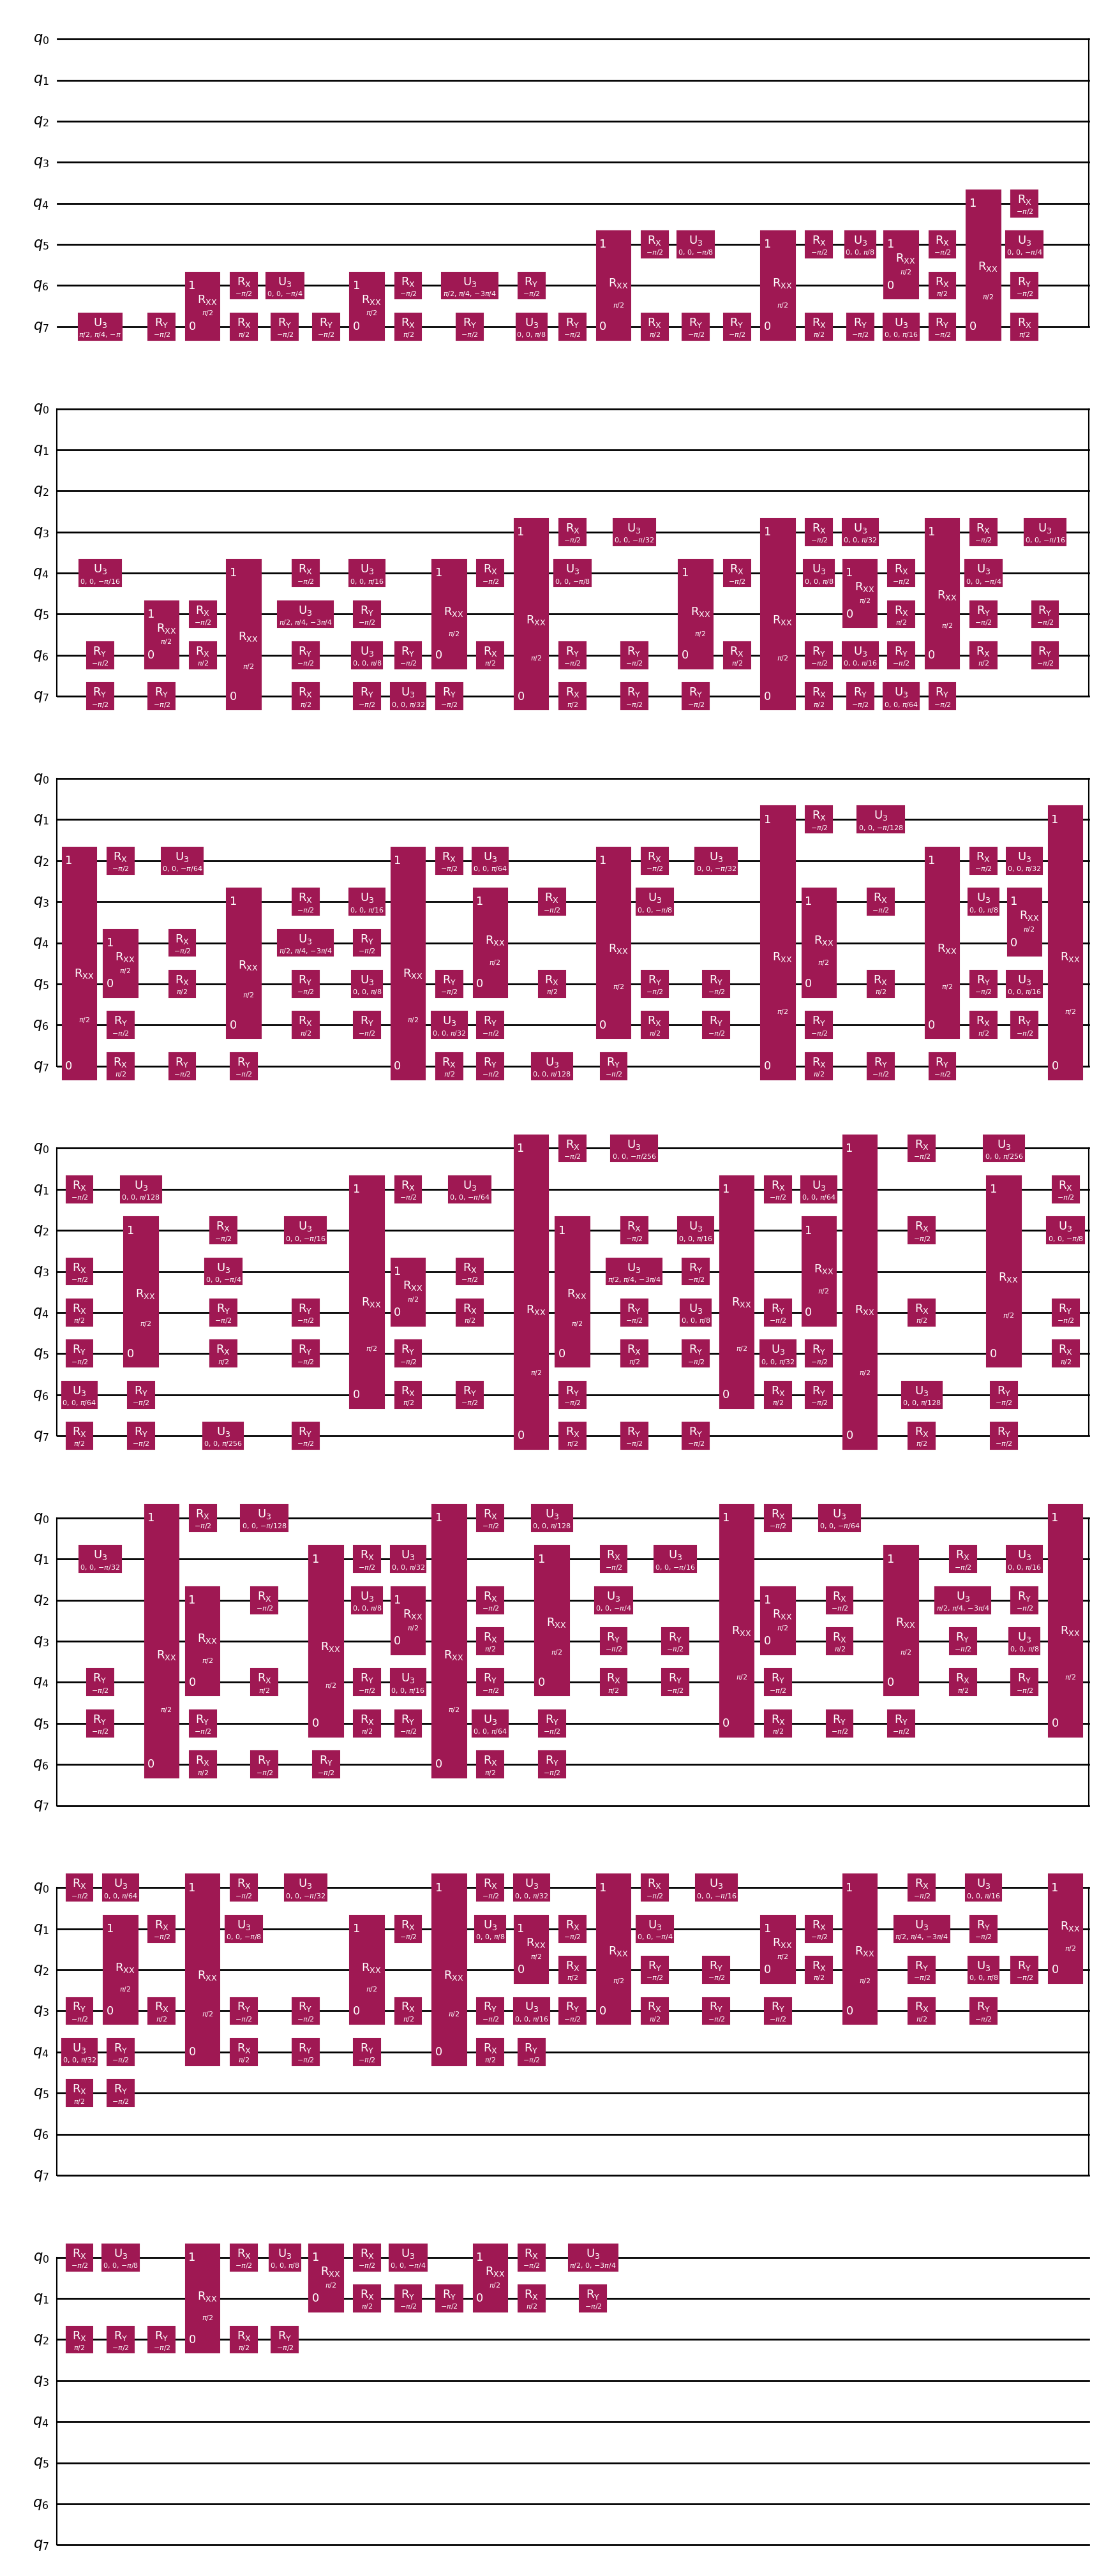

In [5]:
compiled_qft_MSgate = replace_cnot_with_MSgate(compiled_qft)
compiled_qft_MSgate.draw("mpl")

Decompose single qubit gates into RX and RY only

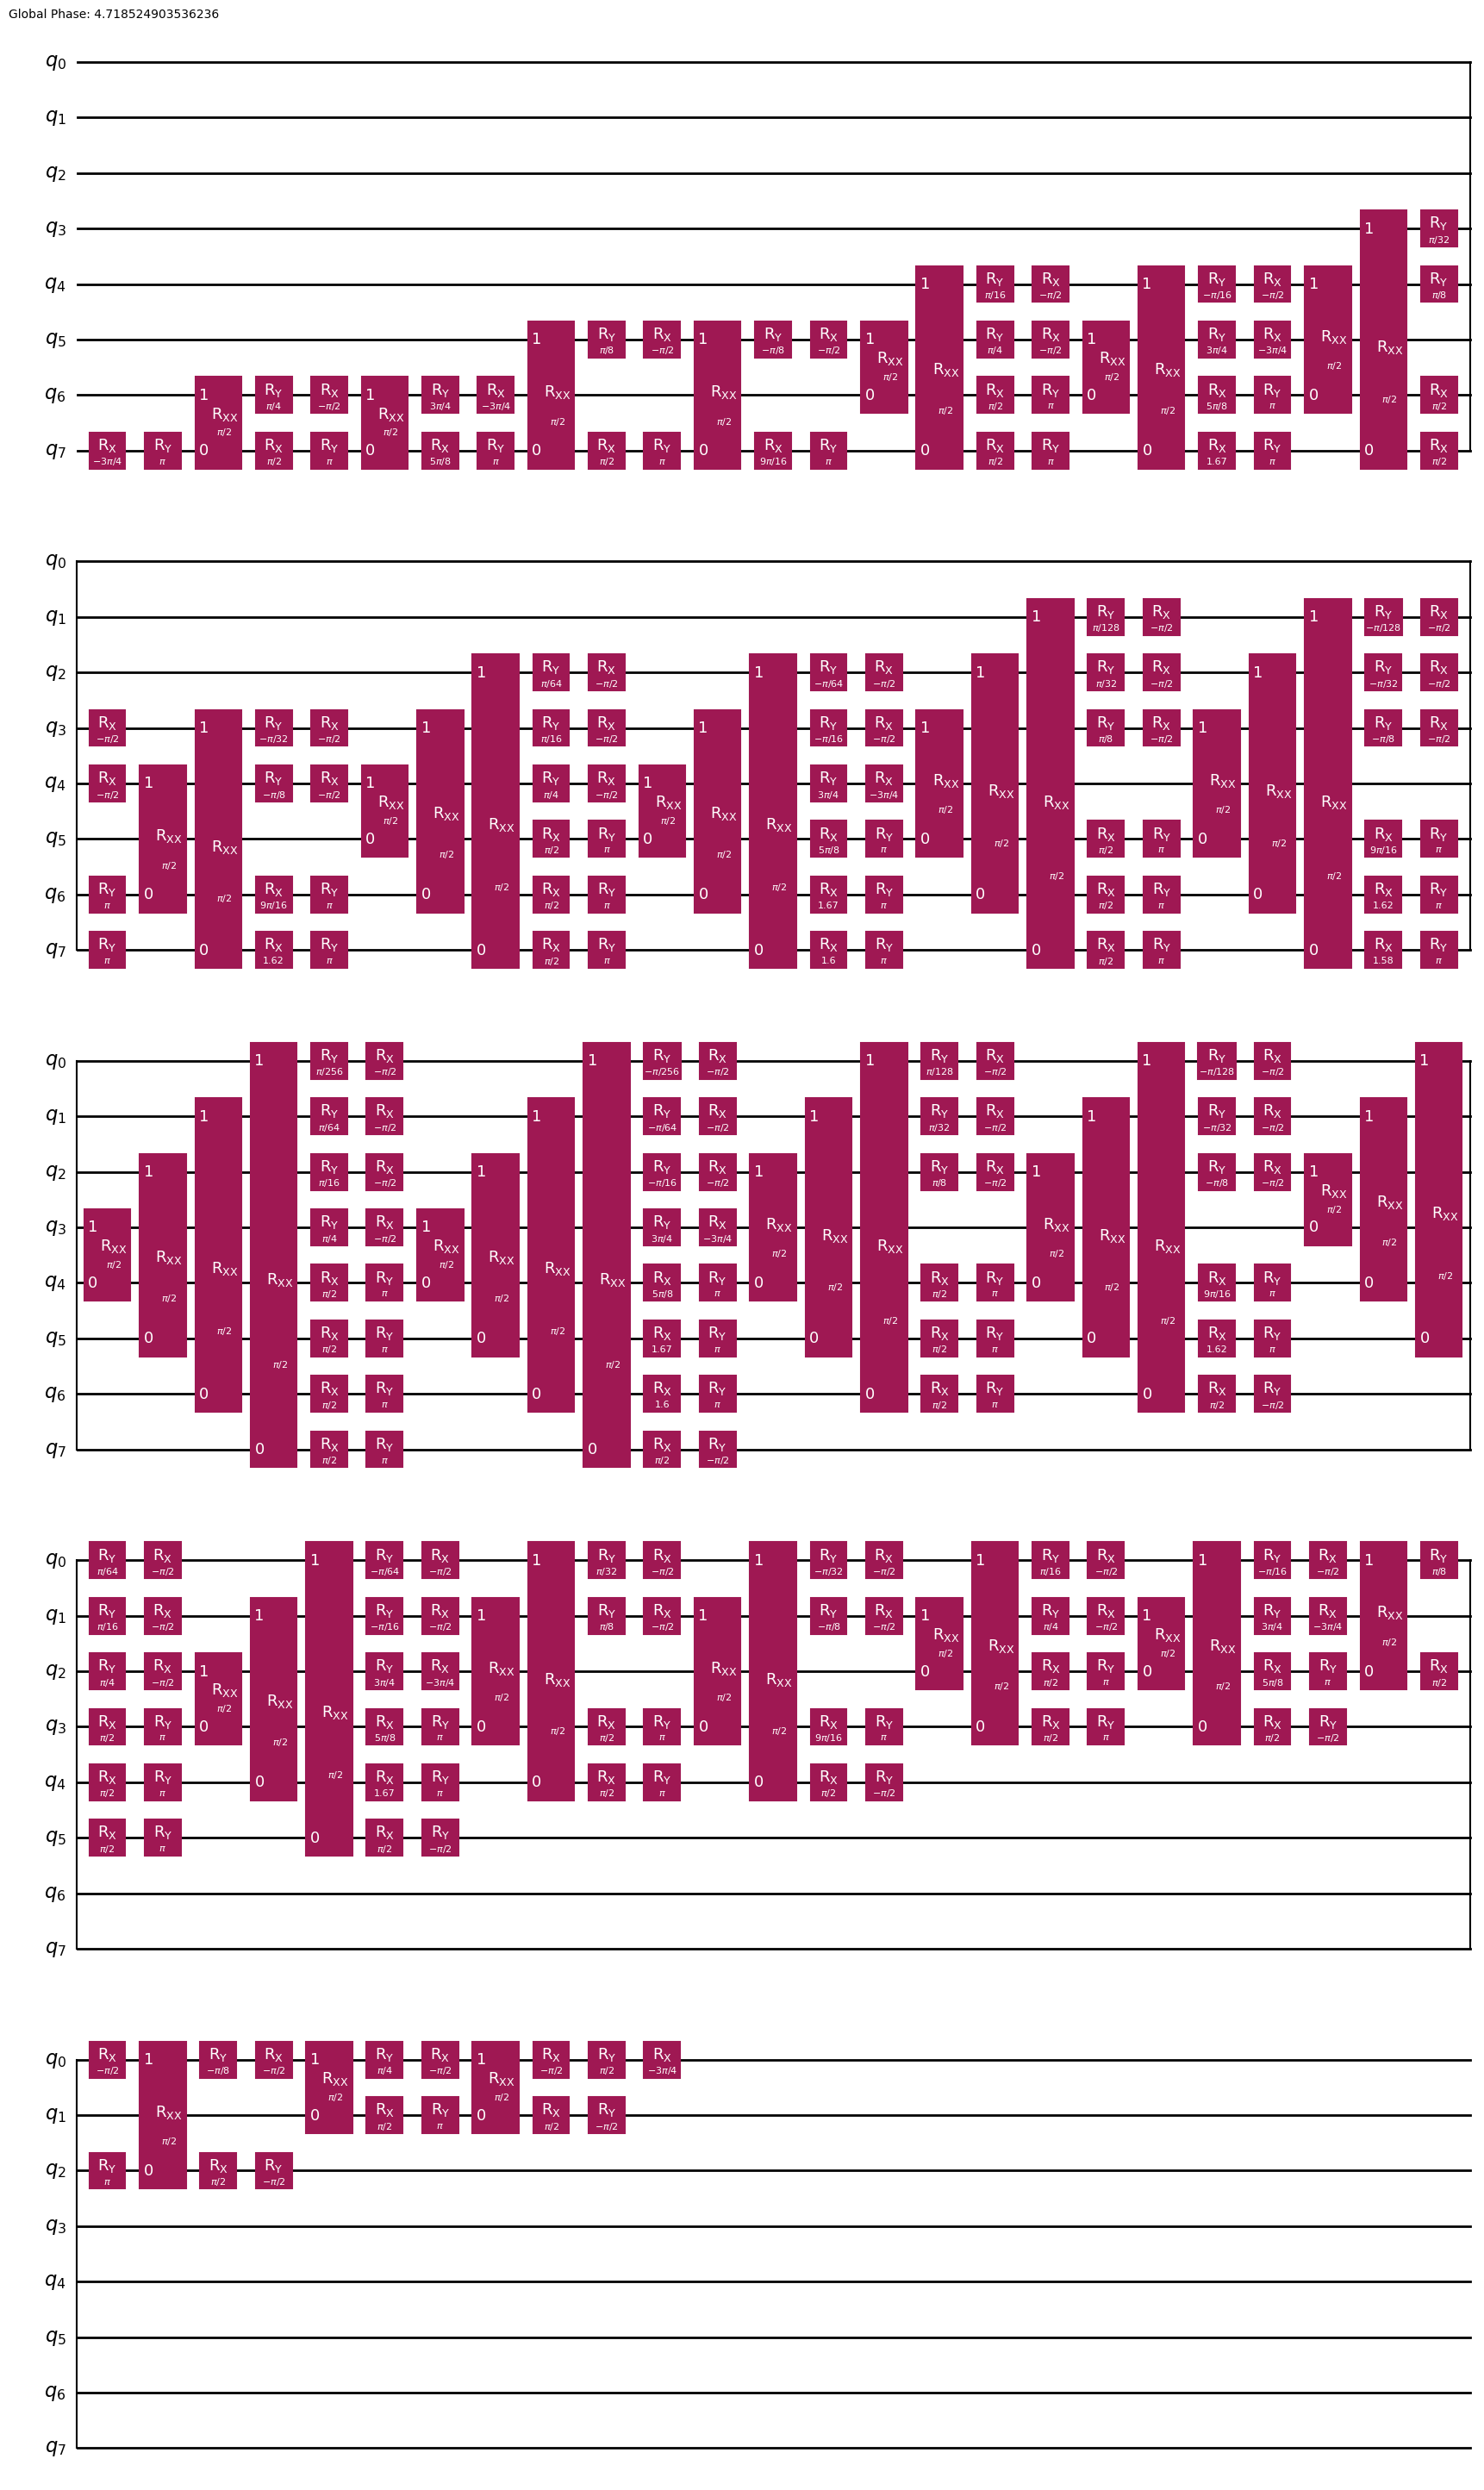

In [6]:
pass_manager = PassManager(Optimize1qGatesDecomposition(basis=['rx', 'ry']))
simplified = pass_manager.run(compiled_qft_MSgate)

simplified.draw("mpl")

# Export the gates in the relevant format

Gate list will be a vector of vectors, each one following the following notation:

An entry represents a list of gates to do in a given time step, defined as
[Ua,Ub,...]
Where U_i is the gate to apply in the time step. A complete list might look like
[
    [Ua,Ub,Uc],
    [Ud],
    [Ue,Uf],
    ...
]

The possible gates U_i are
 - ("RX", angle, ion_index)
 - ("RY", angle, ion_index)
 - ("MS", pi/4, (control_index, target_index))

In [ ]:
from qiskit.converters import circuit_to_dag

In [ ]:
dag = circuit_to_dag(simplified)

for i, layer in enumerate(dag.layers()):
    print(f"Time step {i}: {[op for op in layer['graph'].op_nodes()]}")

In [ ]:
time_steps = []

for i, layer in enumerate(dag.layers()):

    operations = []

    for op in layer['graph'].op_nodes():
        if op.name == 'rx':
            operations.append(('RX', op.params[0], op.qargs[0]._index))
        elif op.name == 'ry':
            operations.append(('RY', op.params[0], op.qargs[0]._index))
        elif op.name == 'rxx':
            operations.append(('MS', np.pi/4, (op.qargs[0]._index, op.qargs[1]._index)))
        else:
            raise ValueError(f"Unsupported operation: {op.name}")
        
    time_steps.append(operations)
        
print(time_steps[0:5])

Export to file

In [ ]:
with open("time_steps_raw.txt", "w") as file:
    for step in time_steps:
        file.write(f"{step}\n")

In [ ]:
with open("time_steps_raw.txt", "r") as file:
    time_steps_list = [eval(line.strip()) for line in file.readlines()]

In [ ]:
print(time_steps_list[0:5])

In [ ]:
print(operations[0][2]._index)